<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/unit8/NityShahU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree

In [ ]:
!pip install pymc-bart
!pip install preliz

In [ ]:
import pymc_bart as pmb
import preliz as pz

In [ ]:
url = 'https://raw.githubusercontent.com/nityamshah/datascience/main/data/API_SI.DST.FRST.20_DS2_en_csv_v2_16880.csv'
data = pd.read_csv(url, skiprows=4, dtype={'Country Name':'category'})
data['countryidx'] = data['Country Name'].cat.codes
data = data.drop(columns=['Unnamed: 68'])
data

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,countryidx
0,Aruba,ABW,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,Africa Eastern and Southern,AFE,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Afghanistan,AFG,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Africa Western and Central,AFW,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,Angola,AGO,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.8,NaN,NaN,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,9.5,9.4,9.2,NaN,NaN,NaN,NaN,NaN,NaN,127
262,"Yemen, Rep.",YEM,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263
263,South Africa,ZAF,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219
264,Zambia,ZMB,Income share held by lowest 20%,SI.DST.FRST.20,NaN,NaN,NaN,NaN,NaN,NaN,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,3.9,NaN,264


My big picture goal is to make a model for developed countries and then another for developing countries and compare them. However, I'm going to begin by just getting my model to work with just the US.

Below I'm cleaning up the dataframe

In [ ]:
# Melt the DataFrame
data = data.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'countryidx'],
                     var_name='Year', value_name='Income Share')

# Convert 'Year' column to numeric
data['Year'] = data['Year'].astype(int)

# Drop rows with NaN values in 'Income Share' if desired
data = data.dropna(subset=['Income Share'])
data

,Country Name,Country Code,Indicator Name,Indicator Code,countryidx,Year,Income Share
1049,United States,USA,Income share held by lowest 20%,SI.DST.FRST.20,253,1963,5.7
1315,United States,USA,Income share held by lowest 20%,SI.DST.FRST.20,253,1964,5.7
1581,United States,USA,Income share held by lowest 20%,SI.DST.FRST.20,253,1965,5.8
1847,United States,USA,Income share held by lowest 20%,SI.DST.FRST.20,253,1966,5.6
2113,United States,USA,Income share held by lowest 20%,SI.DST.FRST.20,253,1967,6.0
...,...,...,...,...,...,...,...
16756,Zambia,ZMB,Income share held by lowest 20%,SI.DST.FRST.20,264,2022,3.9
16806,Costa Rica,CRI,Income share held by lowest 20%,SI.DST.FRST.20,51,2023,4.5
16824,Ecuador,ECU,Income share held by lowest 20%,SI.DST.FRST.20,66,2023,4.7
16864,Indonesia,IDN,Income share held by lowest 20%,SI.DST.FRST.20,112,2023,7.9


Now I'll filter for just the US to make a US model with BART

In [ ]:
#filtering for US data
us_data = data[data['Country Name'] == 'United States']

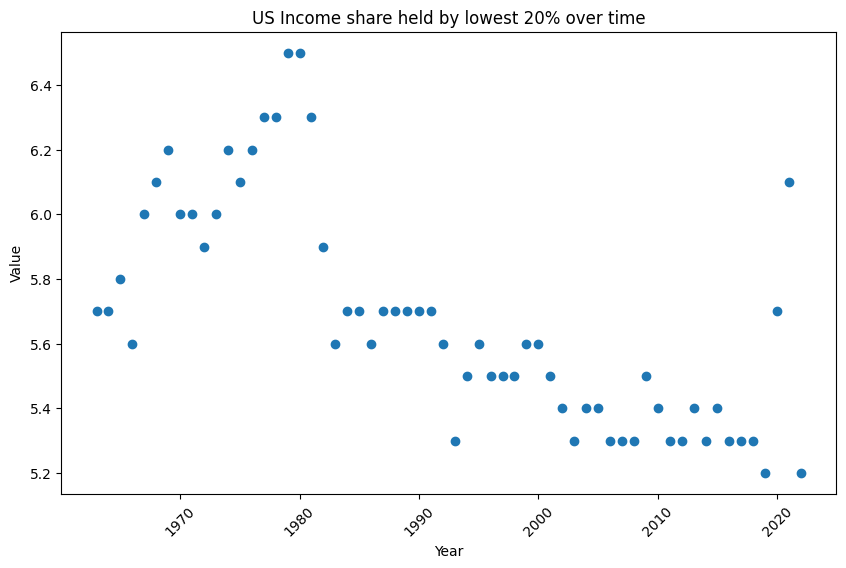

In [ ]:
#Plotting
plt.figure(figsize=(10, 6))
plt.scatter(us_data['Year'], us_data['Income Share'])
plt.title("US Income share held by lowest 20% over time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

In [ ]:
X = us_data['Year'].to_numpy().reshape(-1, 1)
Y = us_data['Income Share'].to_numpy()

In [ ]:
with pm.Model() as model_us:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_us = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

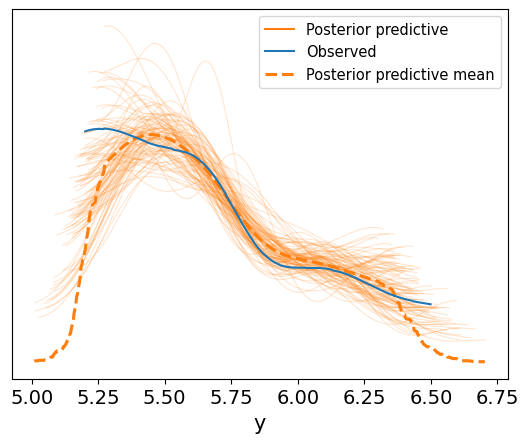

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_us, model_us, extend_inferencedata=True)
az.plot_ppc(idata_us, num_pp_samples=100, colors=["C1", "C0", "C1"])

I would say this model does a pretty good job covering the trend for just the US and I'm happy with it. Now I'd like to try incorporating HDI to factor development in and see if I can make a model for developed and undeveloped countries.

Below is a cleaned dataset of all countries and their HDI as of 2022.

In [ ]:
url = 'https://raw.githubusercontent.com/nityamshah/datascience/main/data/HDR23-24_Statistical_Annex_HDI_Table.csv'
hdi = pd.read_csv(url, skiprows = 6)
hdi = hdi.iloc[:, :3]
hdi = hdi.iloc[:-73]
hdi.rename(columns={'Unnamed: 0': 'HDIRank', 'Unnamed: 1': 'Country', '2022': 'Value'}, inplace=True)
hdi = hdi.dropna(subset=['HDIRank'])
hdi

,HDIRank,Country,Value
1,1.0,Switzerland,0.967
2,2.0,Norway,0.966
3,3.0,Iceland,0.959
4,4.0,"Hong Kong SAR, China",0.956
5,5.0,Denmark,0.952
...,...,...,...
192,189.0,Chad,0.394
193,189.0,Niger,0.394
194,191.0,Central African Republic,0.387
195,192.0,South Sudan,0.381


Here, I'm getting the income share data for the top 10 countries by HDI (well developed countries)

In [ ]:
#top 10 HDI
top10 = hdi[hdi['HDIRank'] <= 10]['Country']
top10list = top10.tolist()
print(top10list)

['Switzerland', 'Norway', 'Iceland', 'Hong Kong SAR, China', 'Denmark', 'Sweden', 'Germany', 'Ireland', 'Singapore', 'Australia', 'Netherlands']


In [ ]:
#filtering for top 10 data
top10_data = data[data['Country Name'].isin(top10list)]
top10_data

,Country Name,Country Code,Indicator Name,Indicator Code,countryidx,Year,Income Share
4213,Sweden,SWE,Income share held by lowest 20%,SI.DST.FRST.20,234,1975,10.1
5231,Norway,NOR,Income share held by lowest 20%,SI.DST.FRST.20,182,1979,9.6
5599,Australia,AUS,Income share held by lowest 20%,SI.DST.FRST.20,13,1981,7.8
5809,Sweden,SWE,Income share held by lowest 20%,SI.DST.FRST.20,234,1981,10.1
5889,Switzerland,CHE,Income share held by lowest 20%,SI.DST.FRST.20,235,1982,7.5
...,...,...,...,...,...,...,...
16183,Sweden,SWE,Income share held by lowest 20%,SI.DST.FRST.20,234,2020,8.2
16284,Denmark,DNK,Income share held by lowest 20%,SI.DST.FRST.20,58,2021,9.2
16337,Ireland,IRL,Income share held by lowest 20%,SI.DST.FRST.20,115,2021,8.9
16402,Netherlands,NLD,Income share held by lowest 20%,SI.DST.FRST.20,173,2021,9.4


In [ ]:
X = top10_data[['Year', 'countryidx']].to_numpy()  # Include Year and Country Code
Y = top10_data['Income Share'].to_numpy()

In [ ]:
with pm.Model() as model_top10:
    s = pm.HalfNormal('s',20) #sigma = 20 is a blind guess
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_top_10 = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

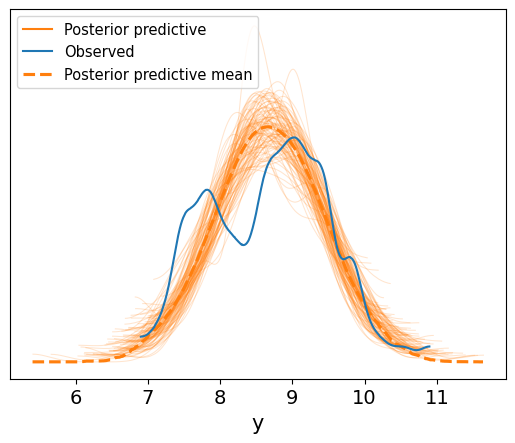

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_top_10, model_top10, extend_inferencedata=True)
az.plot_ppc(idata_top_10, num_pp_samples=100, colors=["C1", "C0", "C1"])

This tells me that there is some hidden pattern or categorical variable that I'm missing. I think that has to do with how some countries trend upwards and some trend downwards. I'm going to plot those out and see.

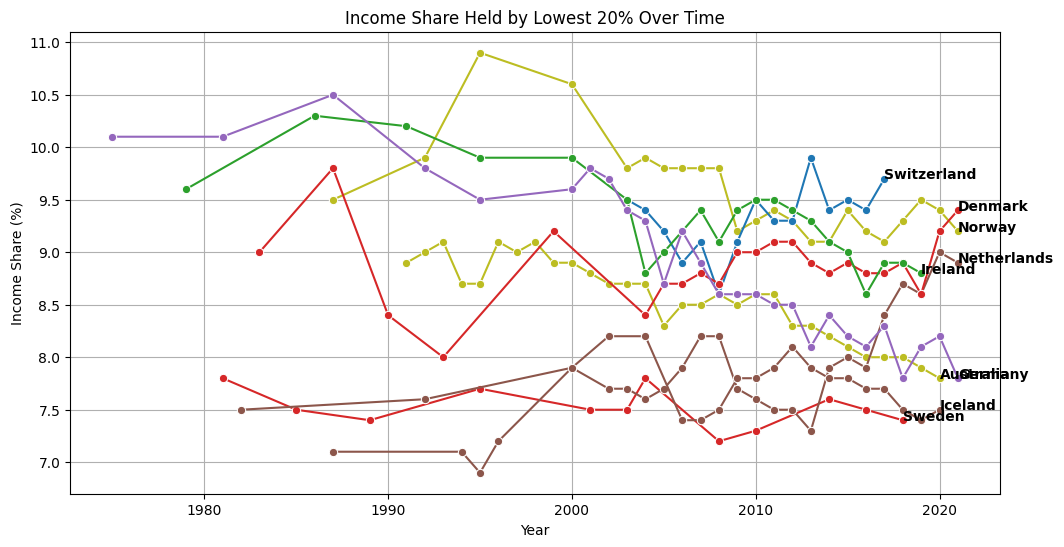

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=top10_data, x='Year', y='Income Share', hue='Country Name',
             marker='o', palette='tab10', legend=False)

plt.title('Income Share Held by Lowest 20% Over Time')
plt.xlabel('Year')
plt.ylabel('Income Share (%)')
plt.grid()

# Get the current axes and lines
lines = plt.gca().lines

# Manually map countries to line colors
countries = top10_data['Country Name'].unique()

for i, line in enumerate(lines):
    x_data = line.get_xdata()
    y_data = line.get_ydata()

    if len(x_data) > 0 and len(y_data) > 0:
        country_name = countries[i]  # Use the unique countries directly
        plt.text(x_data[-1], y_data[-1], country_name,
                 horizontalalignment='left',
                 size='medium',
                 color='black',
                 weight='semibold')

plt.show()

#['Switzerland', 'Norway', 'Iceland', 'Hong Kong SAR, China', 'Denmark', 'Sweden', 'Germany', 'Ireland', 'Singapore', 'Australia', 'Netherlands']

This shows us that within the top HDI, some countries trend upwards while some trend downwards. This probably has something to do with the policies of those countries and their governments. Also, many of the countries dip between 2000 and 2010 which would explain the bimodal nature of the posterior predictive. This is something that can be further explored later with country as a categorical variable, however I wasn't able to get that to work. I also tried the bottom 10 HDI countries, however they don't have much data for income share holdings, making the model quite uncertain. For now, I'm going to try to improve on this bimodal model.

Below, I'm trying a mixture model. This will hopefully capture the two different trends that I'm seeing and the two humps in my observed data.

In [ ]:
X = top10_data[['Year', 'countryidx']].to_numpy()  # Include Year and Country Code
Y = top10_data['Income Share'].to_numpy()

In [ ]:
with pm.Model() as mix_model:
    w = pm.Dirichlet('w', a=np.array([1, 1]))  #w is a vector representing probabilities of observations coming from different mixture components.
    s = pm.HalfNormal('s', 10, shape=2)
    μ_ = pmb.BART("μ_", X, Y, m=100, shape=(2, len(Y)))  #with this, I'm fitting two bart models, one for each component, in the hopes of capturing the bimodal nature
    comp = pm.Categorical('comp', p=w, shape=len(Y)) #comp determines which mixture component an observation goes to
    μ = μ_[comp, np.arange(len(Y))]
    y = pm.Normal("y", mu=μ, sigma=s[comp], observed=Y)
    idata_mix = pm.sample()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:595: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y'>

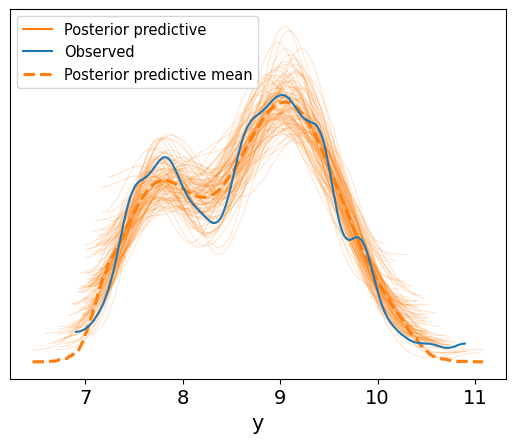

In [ ]:
#generate the posterior predictive dist
pm.sample_posterior_predictive(idata_mix, mix_model, extend_inferencedata=True)
az.plot_ppc(idata_mix, num_pp_samples=100, colors=["C1", "C0", "C1"])

This model could be improved upon, but is much better at capturing the two trends than the previous one.

This analysis has told me that there is some other factor besides HDI that distinguishes how Income Share holdings change over time. This could be something like how the government is run and its policies. So, HDI is not a good variable to use to differentiate countries by income share held by the lowest 20%. Also, getting BART to handle each country as a categorical variable proved difficult, but I learned about mixture models.